In [21]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from ast import literal_eval

In [22]:
# import dataset
user_profile = pd.read_csv("data/User_Profile_Null_Handled.csv")

In [80]:
user_to_query = 'ffffe6d0d44f76428f676bd36e83df76'

In [48]:
data=user_profile.iloc[:,[1,3,11,14,18,23,25,43,48,53,59,61,34]]
data.rename(columns={"Sub_Type":"label"},inplace=True)
data = pd.get_dummies(data, prefix=['Sub_Update'], columns=['Sub_Update_Status'])
# data.drop('Sub_Update_Status', axis=1)

# Label encode class
# le = LabelEncoder()
# data['label'] = le.fit_transform(data.Sub_Type.values)
data = data.drop(['Sub_Update_NO_INFO'], axis=1)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42594 entries, 0 to 42593
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ACCOUNT_NUM.hash                42594 non-null  object 
 1   Voice_INCOMING_Scaled           42594 non-null  float64
 2   Voice_OUTGOING_Scaled           42594 non-null  float64
 3   IDD_INCOMING_Scaled             42594 non-null  float64
 4   IDD_OUTGOING_Scaled             42594 non-null  float64
 5   PEO_TV_Scaled                   42594 non-null  float64
 6   BB_Scaled                       42594 non-null  float64
 7   Megaline_Rental_Scaled          42594 non-null  float64
 8   FTTH_Rental_Scaled              42594 non-null  float64
 9   LTE_Rental_Scaled               42594 non-null  float64
 10  VAS_Rental_Scaled               42594 non-null  float64
 11  label                           42594 non-null  object 
 12  Sub_Update_Promotion Downgrade  

In [50]:
# total number of unique users
data['ACCOUNT_NUM.hash'].nunique()


42594

In [51]:
# total number of unique peo tv package
data['label'].nunique()


5

In [52]:
data.fillna(0,inplace=True)
data_dim=data.iloc[:,[1,2,3,4,5,6,7,8,9,10,12,13]]

## Dimension reduction for rating calculation - Applying PCA

### Find most approporiate no of components

In [53]:
pc=PCA(n_components=12) 
pc.fit(data_dim)

PCA(n_components=12)

In [54]:
#How much variance,caputured individually
pc.explained_variance_

array([1.66313011e-01, 1.33440956e-01, 8.25579255e-02, 7.34568768e-02,
       3.41011303e-02, 1.95787391e-02, 6.89930505e-03, 3.96066719e-03,
       3.54079095e-03, 2.28304784e-03, 2.23635207e-04, 2.31033462e-05])

In [55]:
#How mucb variance, captured together
pc.explained_variance_ratio_.cumsum()

array([0.31595666, 0.56946394, 0.72630511, 0.86585636, 0.93064071,
       0.96783583, 0.98094293, 0.98846729, 0.99519398, 0.99953125,
       0.99995611, 1.        ])

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


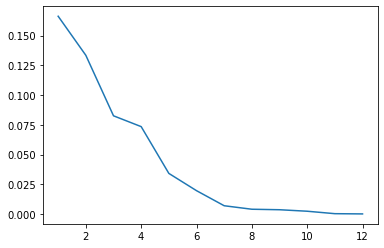

In [56]:
sns.lineplot(range(1,1+pc.explained_variance_.shape[0]),pc.explained_variance_)
plt.show()

### reducing to most appropriate component

In [57]:
### Run PCA on the data and reduce the dimensions in pca_num_components dimensions
pca = PCA(n_components=1)
pca.fit(data_dim)
reduced_data = pca.fit_transform(data_dim)
results_df = pd.DataFrame(reduced_data,columns=['usage'])

In [58]:
# applying min-max-scaler to reduced features
scaler = MinMaxScaler()
results_df[['usage']] = scaler.fit_transform(results_df[['usage']])

In [59]:
data=pd.concat([data,results_df],axis=1)

In [60]:
data = data[["ACCOUNT_NUM.hash","label","usage"]]

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42594 entries, 0 to 42593
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ACCOUNT_NUM.hash  42594 non-null  object 
 1   label             42594 non-null  object 
 2   usage             42594 non-null  float64
dtypes: float64(1), object(2)
memory usage: 998.4+ KB


## Interaction Matrix

In [74]:
# create the user item matrix using the ratings dataset - Hint: try using pivot function 
interactions_metrix = data.pivot_table(index="ACCOUNT_NUM.hash", columns="label", values="usage")
interactions_metrix

label,4G,DOUBLE_PLAY_BV,DOUBLE_PLAY_PV,SINGLE_PLAY,TRIPLE_PLAY
ACCOUNT_NUM.hash,,,,,
0003102d10a11c8f2f0f241f00a36b2d,NaN,NaN,NaN,NaN,0.713319
0003df7598926f578f53ecd9e424f3c9,NaN,0.330602,NaN,NaN,NaN
00092b1fd47eb05d000a3553ae072056,NaN,NaN,NaN,NaN,0.413539
00094326efae1d73371d118204e12e46,NaN,NaN,0.343136,NaN,NaN
000ae59b7eb91e778f22e3f07495f4f9,NaN,0.416101,NaN,NaN,NaN
...,...,...,...,...,...
fff9148b195a844454cf5b07c2fccbcb,NaN,NaN,0.090593,NaN,NaN
fffaeeddaabbd2868c183d8884b2a98d,NaN,NaN,NaN,NaN,0.449490
fffd0b8541e9f62496092d2ea8609135,NaN,NaN,NaN,NaN,0.514746


In [75]:
interactions_metrix.drop(["4G"],axis=1, inplace=True)
#interactions_metrix.reset_index(inplace=True)

# replace all the missing values with zero
interactions_metrix = interactions_metrix.fillna(0)

## Finding similar users

In [76]:
users = data["ACCOUNT_NUM.hash"].values

In [77]:
# using cosine_similarity from sklearn
def similar_users(user_id, interactions_matrix):
    
    # compute similarity of each user to the provided user
    similarity = []
    for user in users:
        sim = cosine_similarity([interactions_metrix.loc[user_id]], [interactions_metrix.loc[user]])
        similarity.append((user, sim))
    
    # sort by similarity
    similarity.sort(key=lambda x: x[1], reverse=True)
    
    # create list of just the user ids
    most_similar_users = [tup[0] for tup in similarity]
    
    # create list of similarity score
    similarity_score = [tup[1] for tup in similarity]
    
    # remove the user's own id
    most_similar_users.remove(user_id)
    
    # remove the user's own similarity score
    similarity_score.remove(similarity_score[0])
       
    return most_similar_users, similarity_score

In [78]:
# check the implemented function above 
#[0] is here to get first returned element of the function (most_similar_users)
#[:10] is to get the first 10 (the 10 most) similar users
similar_users = similar_users(user_to_query, interactions_metrix)[:10]


In [79]:
similar_users[0][:10]

['2240d11b0d9ee8f6d9e8972c6190aa42',
 'f6c68b4d324da04c61da8e877dd4db53',
 '32fcffc5a6e92719c1d426044d450f43',
 '590a953fdfadb4a4a33e1b57af01e72c',
 '317395da96fc088bceb0d7676615aa59',
 '5eb6002bc11ce89a762e1ed37ff99bb8',
 '911b48020851887d4996f4b0b39dd5d1',
 '51bba4dd57389adb7f3c021169b93b60',
 '432a5582be7b20f44843befa4706acbf',
 '22b6f5a9b95d646883c868790b216f04']

In [84]:
# this gives similarity scores ( how similar a user to a given user)
similar_users [1][:10]


[array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]])]

## similarity based collaborative recommendation system

In [85]:
# Business Rule -> Single  Play canot be recommended to a Double Play / Triple Play user
def play_rule(already_interacted):
    for s in already_interacted.copy():
        if "DOUBLE_PLAY" in s or "TRIPLE_PLAY" in s:
            already_interacted.add("SINGLE_PLAY")
    return already_interacted

In [86]:
# test 1
play_rule(set(["TRIPLE_PLAY"]))

{'SINGLE_PLAY', 'TRIPLE_PLAY'}

In [89]:
def recommendations(user_id, num_of_packages, user_item_interactions,similar_users):
    # find the most similar users to the user_id for which we want to recommend packages
    most_similar_users = similar_users[0]
    
    # find out those packages which this user has already interacted with
    packages = set(list(interactions_metrix.columns[np.where(interactions_metrix.loc[user_id]>0)]))
    
    # create an empty list to store the recommended packages
    recommendations = []
    
    # copy those packages which are already interacted by user_id
    already_interacted = packages.copy()
    
    # loop through each similar user from the list of most_similar_users
    for similar_user in most_similar_users:
        
        # implement the below code till the length of recommended packages does not become equal to num_of_packages
        if len(recommendations) < num_of_packages:
            
            # store all the movies interacted by each similar user to user_id
            similar_user_packages = set(list(interactions_metrix.columns[np.where(interactions_metrix.loc[similar_user]>0)]))
            
            # applying business rule
            already_interacted= play_rule(already_interacted)
            
            # add those packages in the recommended list which are present in similar_user_packages but not present in already_interacted
            recommendations.extend(list(similar_user_packages.difference(already_interacted)))
            
            # now add all those packages into already_interacted which we already added in recommendations
            already_interacted = already_interacted.union(similar_user_packages)
            
        else:
            break
    
    return recommendations[:num_of_packages]

In [90]:
# check recommendations
recommendations(user_to_query,1, interactions_metrix, similar_users)

['TRIPLE_PLAY']

### Find Feasible Locations to Recommend Peo TV

In [84]:
user_profile_loc = user_profile.groupby('Location_Identifier').count()["event_source.hash"]

In [85]:
user_profile_peo_loc = user_profile[(user_profile["Sub_Type"] == "TRIPLE_PLAY") | (user_profile["Sub_Type"] == "DOUBLE_PLAY_PV")].groupby('Location_Identifier').count()["event_source.hash"]

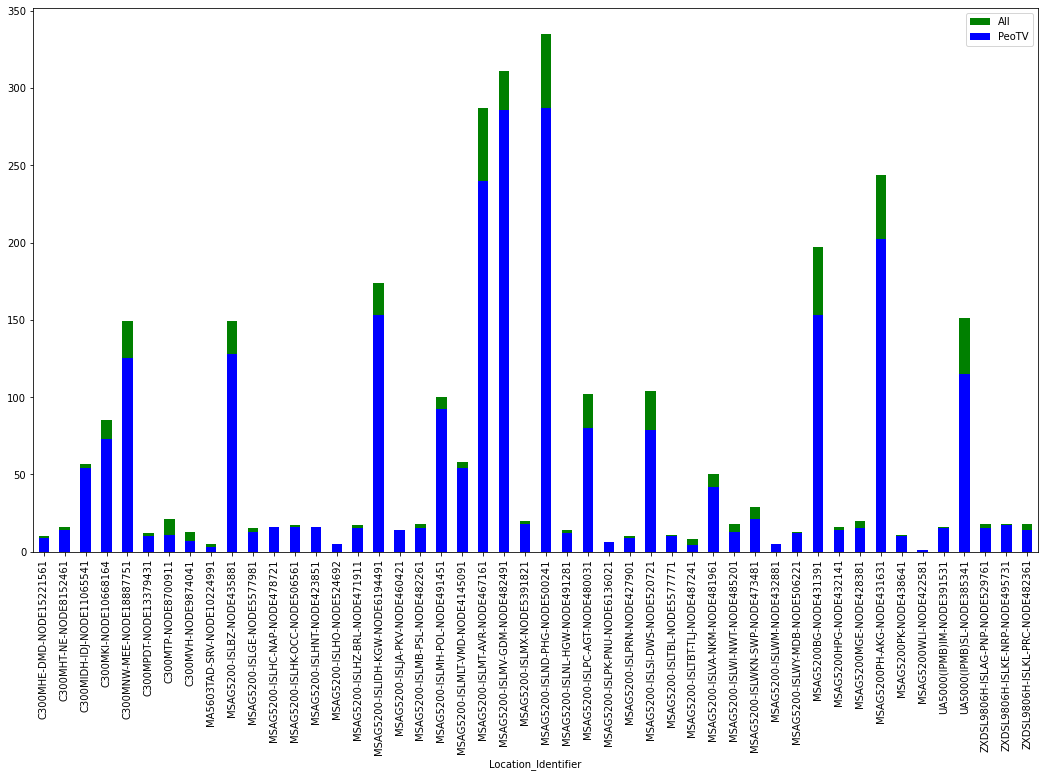

In [86]:
ax = user_profile_loc.plot(stacked=True, kind="bar", figsize=(18,10), color="green")
user_profile_peo_loc.plot(stacked=True, kind="bar",ax=ax, figsize=(18,10), color="blue")
plt.legend(["All","PeoTV"])

In [87]:
loc_precentage=(user_profile_peo_loc/user_profile_loc)*100

In [88]:
loc_precentage[(loc_precentage > 60)]

Location_Identifier
C300MHE-DMD-NODE15221561            90.000000
C300MHT-NE-NODE8152461              87.500000
C300MIDH-IDJ-NODE11065541           94.736842
C300MKI-NODE10668164                85.882353
C300MNW-MEE-NODE18887751            83.892617
C300MPDT-NODE13379431               83.333333
MSAG5200-ISLBZ-NODE435881           85.906040
MSAG5200-ISLGE-NODE5577981          86.666667
MSAG5200-ISLHC-NAP-NODE478721      100.000000
MSAG5200-ISLHK-OCC-NODE506561       94.117647
MSAG5200-ISLHNT-NODE423851         100.000000
MSAG5200-ISLHO-NODE524692          100.000000
MSAG5200-ISLHZ-BRL-NODE471911       88.235294
MSAG5200-ISLIDH-KGW-NODE6194491     87.931034
MSAG5200-ISLJA-PKV-NODE460421      100.000000
MSAG5200-ISLMB-PSL-NODE482261       83.333333
MSAG5200-ISLMH-POL-NODE491451       92.000000
MSAG5200-ISLMLT-VMD-NODE4145091     93.103448
MSAG5200-ISLMT-AVR-NODE467161       83.623693
MSAG5200-ISLMV-GDM-NODE482491       91.961415
MSAG5200-ISLMX-NODE5391821          90.000000
MSAG5200-ISLND

## Feasible locations to offer Broadband

In [89]:
user_profile_bb_loc = user_profile[(user_profile["Sub_Type"] == "TRIPLE_PLAY") | (user_profile["Sub_Type"] == "DOUBLE_PLAY_BV")].groupby('Location_Identifier').count()["event_source.hash"]

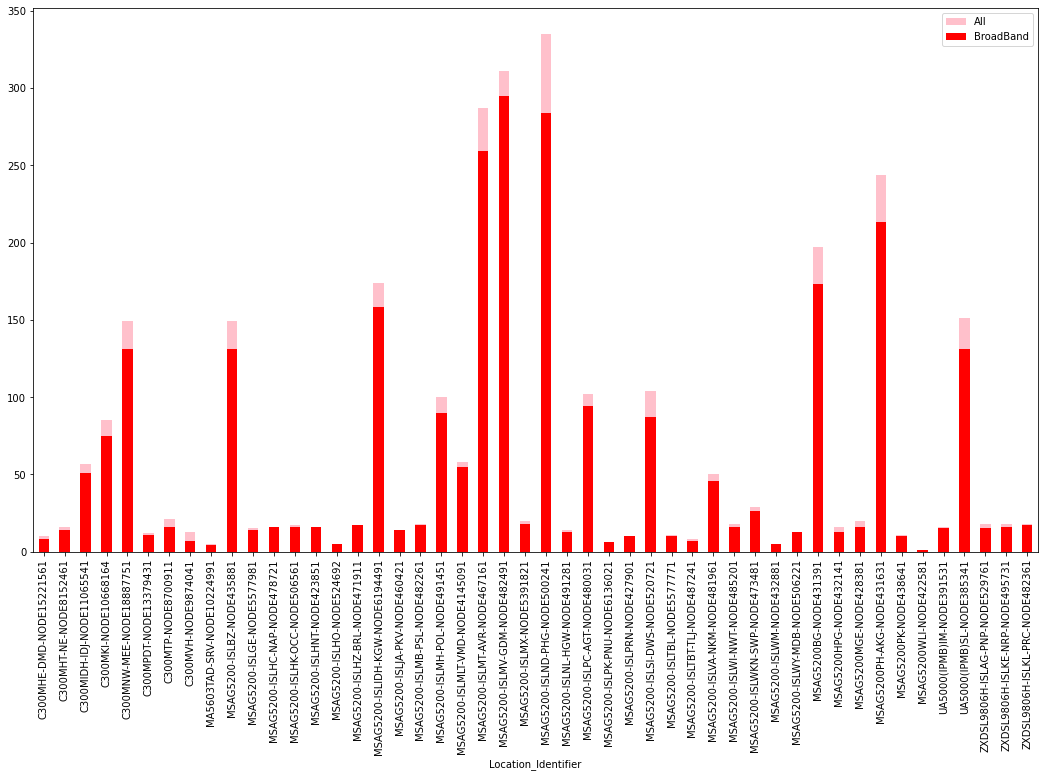

In [90]:
ax = user_profile_loc.plot(stacked=True, kind="bar", figsize=(18,10), color="pink")
user_profile_bb_loc.plot(stacked=True, kind="bar",ax=ax, figsize=(18,10), color="red")
plt.legend(["All","BroadBand"])

In [92]:
loc_precentage=(user_profile_bb_loc/user_profile_loc)*100

In [93]:
loc_precentage[(loc_precentage > 60)]

Location_Identifier
C300MHE-DMD-NODE15221561            80.000000
C300MHT-NE-NODE8152461              87.500000
C300MIDH-IDJ-NODE11065541           89.473684
C300MKI-NODE10668164                88.235294
C300MNW-MEE-NODE18887751            87.919463
C300MPDT-NODE13379431               91.666667
C300MTP-NODE8700911                 76.190476
MA5603TAD-SRV-NODE10224991          80.000000
MSAG5200-ISLBZ-NODE435881           87.919463
MSAG5200-ISLGE-NODE5577981          93.333333
MSAG5200-ISLHC-NAP-NODE478721      100.000000
MSAG5200-ISLHK-OCC-NODE506561       94.117647
MSAG5200-ISLHNT-NODE423851         100.000000
MSAG5200-ISLHO-NODE524692          100.000000
MSAG5200-ISLHZ-BRL-NODE471911      100.000000
MSAG5200-ISLIDH-KGW-NODE6194491     90.804598
MSAG5200-ISLJA-PKV-NODE460421      100.000000
MSAG5200-ISLMB-PSL-NODE482261       94.444444
MSAG5200-ISLMH-POL-NODE491451       90.000000
MSAG5200-ISLMLT-VMD-NODE4145091     94.827586
MSAG5200-ISLMT-AVR-NODE467161       90.243902
MSAG5200-ISLMV

## Feasible users to offer Broadband based on Extra Usage

In [106]:
extra_gb_freq_users = user_profile[(user_profile["BB_Extra_GB_Purchased_Scaled"]>0.75)]

In [107]:
extra_gb_mostly_used_users = extra_gb_freq_users["event_source.hash"]

In [108]:
len(extra_gb_mostly_used_users)

3747

[Text(0, 0, 'e1ac10bab8469ded288550b217cbf9d3'),
 Text(1, 0, '9607cc0961b91d30e160229e012d5e23'),
 Text(2, 0, 'b609c617f800b86dc3f854ee7802aafb'),
 Text(3, 0, '42d32d7357318c518c70f1caf9723383'),
 Text(4, 0, 'fb52262bbefef4500fa112c578f03488'),
 Text(5, 0, 'e0cb021dd600cd4f68d9aae5127812d7'),
 Text(6, 0, 'b724383ac532863f86d3a44f96338cf0'),
 Text(7, 0, '634fa98198a6c8ca97c58a541b78b956'),
 Text(8, 0, '1c47b29a848493069e30cea3feebf666'),
 Text(9, 0, '581baa49b1a00756f13e1e203fd77b51'),
 Text(10, 0, 'e87ab34fb3ab722b488fe398d735f9dd'),
 Text(11, 0, '535d6d2c263332fe6eba1b9feccc7721'),
 Text(12, 0, '9ae854b8429d346f997f0794f57fb0c7'),
 Text(13, 0, '7d3740bfd42f9134a22a620329a87f17'),
 Text(14, 0, 'f97b4cd74ac3c61f446c55235b81c8c6'),
 Text(15, 0, 'b8bf0deced7240592758132834081801'),
 Text(16, 0, 'f011214ffc9e1b27b22efb6bb7ed4387'),
 Text(17, 0, '4ece622aee38a286421dedd1a4bdfb98'),
 Text(18, 0, '212c6a20f043f3da76f2ce780beb7a27'),
 Text(19, 0, '5966f6c6a0b4fa2edd5b5defc782e6a4')]

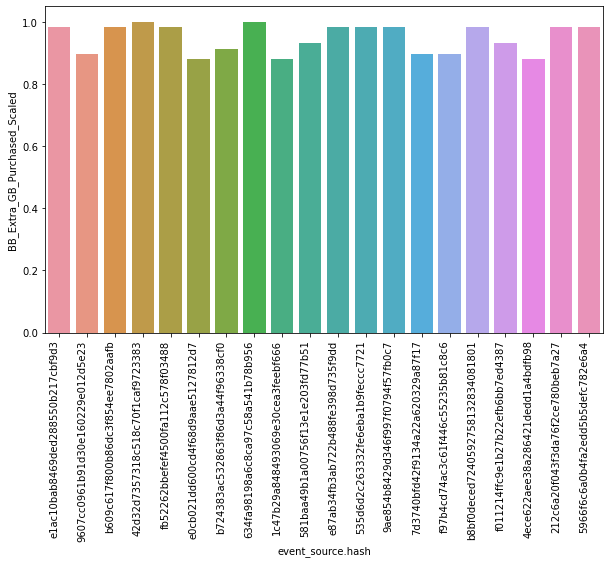

In [109]:
plt.figure(figsize=(10,6))
extra_gb_bar_plot = sns.barplot(data=extra_gb_freq_users.sample(n=20),x='event_source.hash', y='BB_Extra_GB_Purchased_Scaled')

extra_gb_bar_plot.set_xticklabels(extra_gb_bar_plot.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')

## Evaluation